# 02807 – Computational Tools for Data Science  
## Final Project: Hybrid Movie Recommendation System
**Student: Bashar Bdewi, s183356**

In this project we implement a small hybrid movie recommender system to generate personalized movie recommendations using:

- **Course topic:** k-means clustering on user–item rating data  
- **Extra method (outside the course):** TF-IDF content-based features from movie genres  

The goals of the project are:
1. Load and clean the MovieLens-like Kaggle movie dataset.  
2. Build a simple popularity-based baseline recommender.  
3. Build a cluster-based recommender using k-means on user rating vectors.  
4. Build a content-based module using TF-IDF on movie genres.  
5. Combine them into a hybrid recommender and evaluate it with hit-rate@K.


---

## 0. Setup



In [ ]:
# === Imports ===
import pandas as pd         
import numpy as np           

from sklearn.model_selection import train_test_split        
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import KMeans                          
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score

import matplotlib.pyplot as plt   
import ast                        


# === Reproducibility ===
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports completed. Ready to continue.")


---

## 1. Data: Loading, Cleaning, and Exploration

### 1.1 Load raw data



we load the two main CSV files that we will use throughout the project:

- `ratings_small.csv`:  Contains user–movie ratings. Each row tells us:
  - which user (`userId`)
  - which movie (`movieId`)
  - what rating they gave (`rating`)

<br>

- `movies_metadata.csv`: Contains information about each movie, including:
  - a movie identifier (`id`, which we will later align with `movieId`)
  - the movie title (`title`)
  - the movie genres (`genres` stored in a JSON-like string)



In [209]:
# === Load rating and movie data from CSV files ===

# Paths to the CSV files
ratings_path = "data/ratings_small.csv"
movies_path = "data/movies_metadata.csv"

# Load the ratings file
ratings = pd.read_csv(ratings_path)

# Load the movies metadata file
movies_raw = pd.read_csv(movies_path, low_memory=False)

print("✅ Data files loaded.")
print("Ratings shape:", ratings.shape)
print("Movies (raw) shape:", movies_raw.shape)

# Show the first few rows of each table to visually inspect the contents
print("\nSample of ratings:")
display(ratings.head())

print("\nSample of movies_raw:")
display(movies_raw.head())


✅ Data files loaded.
Ratings shape: (100004, 4)
Movies (raw) shape: (45466, 24)

Sample of ratings:


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205



Sample of movies_raw:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


### 1.2 Clean movie metadata and align IDs

The raw `movies_metadata.csv` file contains many columns and some noise.  
In this step, we:

- Keep only `movieId`, `title`, `genres`.
- Filter to movies that appear in the ratings.
- Create `genres_str` (e.g. `"Drama Crime Thriller"`).




In [212]:
# === Clean the movies table and align movie IDs ===


# keep only the columns we care about 
movies = movies_raw[['id', 'title', 'genres']].copy()

# The 'id' column in movies_metadata is currently a string and may contain bad values.
# We convert it to a numeric type and drop rows where this conversion fails.
movies['id'] = pd.to_numeric(movies['id'], errors='coerce')
movies = movies.dropna(subset=['id'])
movies['id'] = movies['id'].astype(int)

# Rename 'id' to 'movieId' so that it matches the 'movieId' column in the ratings table
movies = movies.rename(columns={'id': 'movieId'})

# Now we restrict the movies table to only those movieIds that appear in the ratings data
movie_ids_in_ratings = ratings['movieId'].unique()
movies = movies[movies['movieId'].isin(movie_ids_in_ratings)]

print("✅ Cleaned movies table created.")
print("Movies shape after cleaning:", movies.shape)

# Show a few example rows to verify the result.
movies.head()


✅ Cleaned movies table created.
Movies shape after cleaning: (2831, 3)


,movieId,title,genres
5,949,Heat,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam..."
9,710,GoldenEye,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '..."
14,1408,Cutthroat Island,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam..."
15,524,Casino,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name..."
16,4584,Sense and Sensibility,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n..."


### 1.3 Parse the `genres` column into a clean text field

In the `movies` table, the `genres` column is stored as a JSON-like string, for example:

- `[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}]`

This format is not directly usable for TF-IDF.  
In this step, we:

1. Safely parse the `genres` string into a Python list of dictionaries.
2. Extract only the `name` field from each genre.
3. Join all genre names into a single space-separated string, for example`"Animation Comedy"`.

We store this cleaned text in a new column called `genres_str`, which will later be used as input to the TF-IDF vectorizer.


In [215]:
# === Convert the raw 'genres' field into a clean text column 'genres_str' ===


def parse_genres(genres_value):
    """
    Parse the raw 'genres' text into a space-separated string of genre names.
    
    If the value is missing or malformed, return an empty string.
    """
    # Handle missing or empty cases
    if pd.isna(genres_value) or genres_value == '[]':
        return ''
    
    try:
        # Safely evaluate the string into a Python object (usually a list of dicts)
        data = ast.literal_eval(genres_value)
        
        # We expect 'data' to be a list of dictionaries with a 'name' field
        if isinstance(data, list):
            names = []
            for g in data:
                if isinstance(g, dict):
                    name = g.get('name', '')
                    if isinstance(name, str) and name:
                        names.append(name)
            # Join all genre names with spaces
            return ' '.join(names)
        
        # If the structure is not as expected, return empty string
        return ''
    
    except (ValueError, SyntaxError):
        # If parsing fails for any reason, return empty string
        return ''

# Apply the parser to the 'genres' column to create a new 'genres_str' column
movies['genres_str'] = movies['genres'].apply(parse_genres)

print("✅ genres_str column created.")
movies[['movieId', 'title', 'genres', 'genres_str']].head()


✅ genres_str column created.


,movieId,title,genres,genres_str
5,949,Heat,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Action Crime Drama Thriller
9,710,GoldenEye,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",Adventure Action Thriller
14,1408,Cutthroat Island,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",Action Adventure
15,524,Casino,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",Drama Crime
16,4584,Sense and Sensibility,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",Drama Romance


### 1.4 Basic statistics, train/test split, and user–item matrix


Before building any recommender, we need to:

1. **Inspect the ratings data briefly**  
   - How many users are there?  
   - How many movies?  
   - What does the rating distribution look like?

<br>

2. **Split the ratings into train and test sets**  (80/20).
   - The train set is used to "learn" patterns (for clustering and recommendations).  
   - The test set is kept aside and used only to evaluate how good the recommender is.  
 
<br>

3. **Build the user–item rating matrix from the train set**  
   - Rows: users (`userId`)  
   - Columns: movies (`movieId`)  
   - Cell (u, m): the rating user *u* gave to movie *m* (NaN if no rating)  

<br>

   This matrix is the basis for:
   - k-means clustering on user rating vectors  
   - later, computing recommendations per user  

   We will also create a version where missing values are filled with 0.0, which is what k-means will use.


In [218]:
# --- 1 Basic statistics on the ratings data ---

# Number of unique users
n_users = ratings['userId'].nunique()

# Number of unique movies
n_movies = ratings['movieId'].nunique()

print("Number of unique users :", n_users)
print("Number of unique movies:", n_movies)
print("\nRatings summary (distribution of rating values):")
print(ratings['rating'].describe())

Number of unique users : 671
Number of unique movies: 9066

Ratings summary (distribution of rating values):
count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


In [220]:
# --- 2 Train/Test split on the ratings ---

# test_size=0.2 means 20% of the ratings go into the test set.
# random_state makes the split reproducible.
train_ratings, test_ratings = train_test_split(
    ratings,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print("\nTrain ratings shape:", train_ratings.shape)
print("Test ratings shape :", test_ratings.shape)



Train ratings shape: (80003, 4)
Test ratings shape : (20001, 4)


In [222]:
# --- 3 Build the user–item rating matrix from the training data ---

# We pivot the training ratings into a matrix:
#   rows   = userId
#   columns= movieId
#   values = rating
user_item = train_ratings.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
)

print("\nUser–item matrix shape (with NaNs):", user_item.shape)

# For k-means, we will use a version where missing ratings are filled with 0.
# This does NOT mean the user truly rated 0; it simply indicates "no rating" in this context.
user_item_filled = user_item.fillna(0.0)

print("User–item matrix shape (filled with 0.0):", user_item_filled.shape)

# inspect the first few rows to get a feeling of the structure.
user_item.head()



User–item matrix shape (with NaNs): (671, 8399)
User–item matrix shape (filled with 0.0): (671, 8399)


movieId,1,2,3,4,5,6,7,8,9,10,...,160656,160718,161084,161155,161594,161830,161918,161944,162542,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.5 Exploratory plots
- Histogram of rating values.
- Distribution of ratings per user.
- Distribution of ratings per movie.



**1.5a Distribution of rating values**

As a simple exploratory plot, we can visualise how rating values are distributed
across the entire dataset. This helps us see whether users tend to give mostly
high ratings, low ratings, or use the full scale.


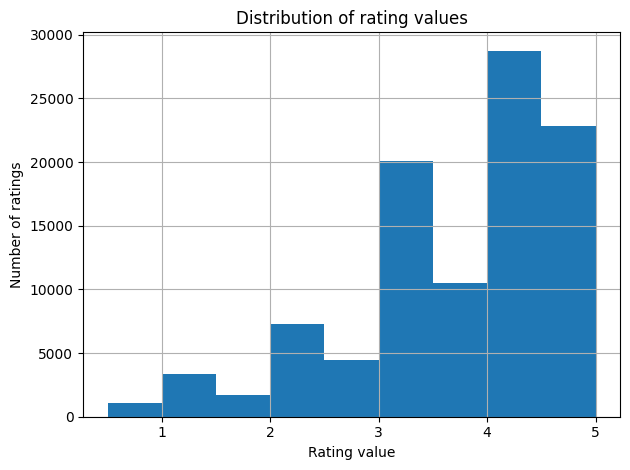

In [226]:
# Distribution of rating values

plt.figure()
# Use a histogram with bins covering 0.5 to 5.0
bins = np.arange(0.5, 5.5, 0.5)
ratings['rating'].hist(bins=bins)

plt.xlabel("Rating value")
plt.ylabel("Number of ratings")
plt.title("Distribution of rating values")
plt.tight_layout()
plt.show()


>    Ratings are strongly skewed toward the positive end of the scale: most ratings are 3, 4, or 5 stars, while very low ratings are rare. This indicates a clear “positivity bias”, which is common in explicit feedback datasets where users are more likely to rate items they enjoyed.

**1.5b Number of ratings per user**

We also look at how many ratings each user has made. This tells us how sparse
the data is from the user side (how many "active" and "inactive" users we have).


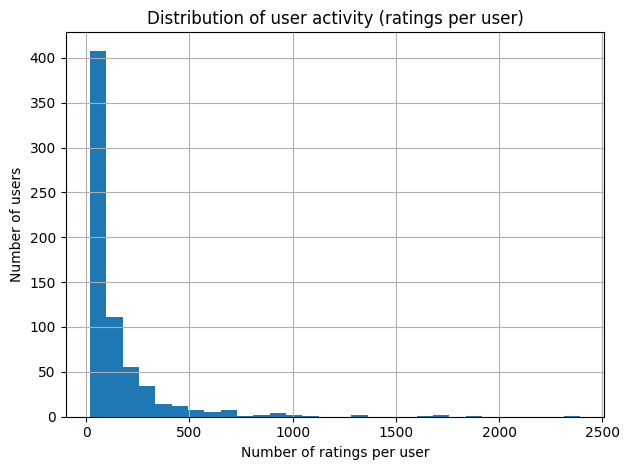

In [230]:
# Distribution of number of ratings per user

user_counts = ratings.groupby("userId")["movieId"].count()

plt.figure()
user_counts.hist(bins=30)

plt.xlabel("Number of ratings per user")
plt.ylabel("Number of users")
plt.title("Distribution of user activity (ratings per user)")
plt.tight_layout()
plt.show()


>    Most users have only a small number of ratings, while a few users are extremely active and contribute hundreds or even thousands of ratings. This heavy-tailed pattern shows that the dataset contains many “cold” users with limited information, which makes personalised recommendation more challenging.


**1.5c Number of ratings per movie**

Similarly, we examine how many ratings each movie has received. This shows how
popular or obscure most movies are in the dataset.


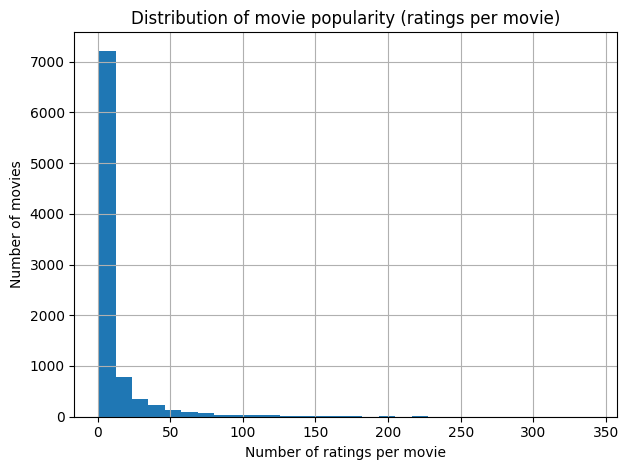

In [234]:
# Distribution of number of ratings per movie

movie_counts = ratings.groupby("movieId")["userId"].count()

plt.figure()
movie_counts.hist(bins=30)

plt.xlabel("Number of ratings per movie")
plt.ylabel("Number of movies")
plt.title("Distribution of movie popularity (ratings per movie)")
plt.tight_layout()
plt.show()


>    The majority of movies receive very few ratings, whereas a small subset of popular movies accumulate many ratings. 

---

## 2. Popularity-based baseline recommender

Before building more advanced models, we define a very simple baseline recommender that always recommends the same “most popular” movies to every user.



This model does not personalize recommendations to each user, but is a useful **baseline** to compare against the cluster-based and hybrid recommenders later.


First we compute mean rating and rating count per movie (train only). 

In [239]:
# For each movie we compute: movie_mean and movie_count
movie_mean = train_ratings.groupby('movieId')['rating'].mean()
movie_count = train_ratings.groupby('movieId')['rating'].count()

print("Computed mean rating and rating counts for movies in the training set.")
print("Number of movies with at least one rating in train:", len(movie_mean))

Computed mean rating and rating counts for movies in the training set.
Number of movies with at least one rating in train: 8399


Now for a given `top_n`, we simply return the movies with the highest mean rating among those with at least `min_ratings` ratings.

In [242]:
def recommend_popular(top_n: int = 10, min_ratings: int = 20) -> pd.DataFrame:
    """
    Recommend the same top-N most popular movies to any user.

    A movie is considered 'eligible' if:
      - it appears in the training data, and
      - it has at least `min_ratings` ratings.

    Among the eligible movies, we sort by the mean rating (descending)
    and return the top-N.

    Parameters
    ----------
    top_n : int
        How many movies to return.
    min_ratings : int
        Minimum number of ratings a movie must have to be considered.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the recommended movies with:
        - movieId
        - title
    """
    # Filter movies that have at least `min_ratings` ratings
    eligible = movie_mean[movie_count >= min_ratings]

    if eligible.empty:
        print("Warning: No movies meet the min_ratings requirement. "
              "Try reducing min_ratings.")
        return movies[['movieId', 'title']].head(top_n)

    # Take the top-N movies by mean rating
    top_movie_ids = eligible.sort_values(ascending=False).head(top_n).index

    # Build a DataFrame from these ids to preserve order
    recs = pd.DataFrame({'movieId': top_movie_ids})

    # Merge with the movies table to get titles.
    recs = recs.merge(movies[['movieId', 'title']], on='movieId', how='left')

    # drop rows with missing titles 
    recs = recs.dropna(subset=['title'])

    return recs

Then show the top-10 popular movies

In [245]:
popular_recs_example = recommend_popular(top_n=10, min_ratings=20)
print("\nExample: Top-10 globally popular movies (training set):")
display(popular_recs_example)


Example: Top-10 globally popular movies (training set):


,movieId,title
0,1945,Nell
1,858,Sleepless in Seattle
2,318,The Million Dollar Hotel
6,2064,While You Were Sleeping
8,913,The Thomas Crown Affair


---

## 3. Cluster-Based Recommender (k-means)

In this step we introduce the **course topic**: general clustering (k-means).

We use the user–item rating matrix built from the training set, then we apply k-means to group users into `K` clusters based on their rating patterns where users in the same cluster are assumed to have similar tastes. We then tore `user_to_cluster` mapping building a small DataFrame with `userId` and `cluster` (cluster index from 0 to K−1).

This gives us a **personalised** recommender based purely on “people like you” (collaborative filtering via clustering).


### 3.1 K-means on user rating vectors

In [251]:
# === Run K-means clustering on user rating vectors ===


# Number of clusters for users
N_CLUSTERS = 20

# Fit k-means on the filled user–item matrix (rows = users, columns = movies).
kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=RANDOM_STATE,
    n_init=10  
)

# user_clusters[i] is the cluster index of the i-th row in user_item_filled
user_clusters = kmeans.fit_predict(user_item_filled)

# Build a small table mapping each userId to its cluster
user_cluster_df = pd.DataFrame({
    "userId": user_item_filled.index,
    "cluster": user_clusters
})

print("✅ K-means clustering completed.")
print("Number of clusters:", N_CLUSTERS)
print("\nCluster size (top 10):")
display(user_cluster_df["cluster"].value_counts().head(10))


✅ K-means clustering completed.
Number of clusters: 20

Cluster size (top 10):


cluster
17    330
13    129
10     87
0      46
5      40
9      20
1       4
14      2
3       2
6       1
Name: count, dtype: int64

### 3.2 Cluster-only recommender

In [254]:
# === Define the cluster-based recommender ===

# Convenience mapping: userId -> cluster index
user_to_cluster = dict(zip(user_cluster_df["userId"], user_cluster_df["cluster"]))


def recommend_from_cluster(user_id: int, top_n: int = 10, min_ratings: int = 5) -> pd.DataFrame:
    """
    Recommend movies to a user based only on the ratings given by
    users in the same cluster.

    Steps:
      1. Find the cluster of `user_id`.
      2. Collect ratings from all users in that cluster.
      3. Compute the mean rating per movie and how many times each movie
         was rated inside the cluster.
      4. Filter to movies with at least `min_ratings` ratings.
      5. Remove movies already rated by `user_id`.
      6. Return the top-N remaining movies, sorted by cluster mean rating.

    If there are no suitable candidates, we fall back to the global
    popularity recommender.
    """
    if user_id not in user_to_cluster:
        raise ValueError(f"user_id {user_id} not found in training set")

    # 1) Find the cluster of this user
    cluster_id = user_to_cluster[user_id]

    # 2) All users in the same cluster
    cluster_users = user_cluster_df[user_cluster_df["cluster"] == cluster_id]["userId"]

    # 3) Ratings from users in this cluster
    cluster_ratings = train_ratings[train_ratings["userId"].isin(cluster_users)]

    # Mean rating and count per movie inside the cluster
    cluster_movie_mean = cluster_ratings.groupby("movieId")["rating"].mean()
    cluster_movie_count = cluster_ratings.groupby("movieId")["rating"].count()

    # 4) Keep only movies with at least `min_ratings` ratings in this cluster
    eligible = cluster_movie_mean[cluster_movie_count >= min_ratings]

    # 5) Remove movies that the target user has already rated in the train set
    seen_movies = set(
        train_ratings[train_ratings["userId"] == user_id]["movieId"]
    )
    eligible = eligible[~eligible.index.isin(seen_movies)]

    # If no candidates left, fall back to popularity-based recommendations
    if eligible.empty:
        print("Cluster-based recommender: no candidates found, falling back to popularity.")
        return recommend_popular(top_n=top_n, min_ratings=10)

    # 6) Take the top-N movies by cluster mean rating
    top_movie_ids = eligible.sort_values(ascending=False).head(top_n).index

    # Build a DataFrame with movieId and title (if available)
    recs = pd.DataFrame({"movieId": top_movie_ids})
    recs = recs.merge(movies[["movieId", "title"]], on="movieId", how="left")
    recs = recs.dropna(subset=["title"])

    return recs

In [256]:
# --- Quick check ---

# Pick one example user from the user–item matrix
example_user = int(user_item.index[0])
print(f"Example user: {example_user}")

cluster_recs_example = recommend_from_cluster(example_user, top_n=10, min_ratings=5)
print("\nExample: Top-10 cluster-based recommendations for this user:")
display(cluster_recs_example)


Example user: 1

Example: Top-10 cluster-based recommendations for this user:


,movieId,title
0,2202,Lassie Come Home
1,2064,While You Were Sleeping
2,162,Edward Scissorhands
3,1945,Nell


### 3.3 Cluster diagnostics
- Bar plot: users per cluster.
- Davies–Bouldin index for the clusters.
- PCA 2D scatter plot of users coloured by cluster.



To better understand the clustering step, we can visualise how many users are
assigned to each cluster. This helps us see whether some clusters dominate or
if the users are more evenly distributed.


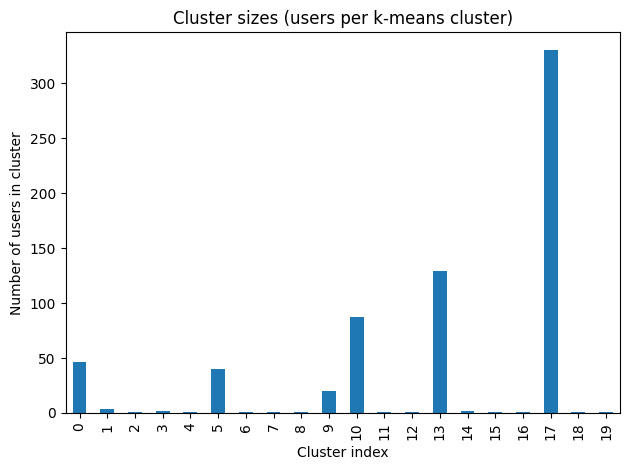

In [260]:
# Cluster sizes (number of users per cluster)

cluster_sizes = user_cluster_df['cluster'].value_counts().sort_index()

plt.figure()
cluster_sizes.plot(kind='bar')

plt.xlabel("Cluster index")
plt.ylabel("Number of users in cluster")
plt.title("Cluster sizes (users per k-means cluster)")
plt.tight_layout()
plt.show()


> The clustering is very unbalanced and k-means didn’t find 20 equally-sized groups, but a few big “generic” clusters plus several small ones with special/odd rating patterns. Clusters are not very well separated → cluster-only recommender does not clearly beat popularity.


Compute Davies–Bouldin index for the user clusters. Lower is better (more compact and well-separated clusters).

In [268]:
db_index = davies_bouldin_score(user_item_filled.values, user_clusters)
print(f"Davies–Bouldin index for k-means user clusters: {db_index:.3f}")


Davies–Bouldin index for k-means user clusters: 2.052


> We obtained a value of 2.052. This relatively high value indicates that the clusters are not very well separated or compact, which is consistent with the limited performance gains of the cluster-based recommender over the simple popularity baseline.

Since the user–item rating matrix is high-dimensional, we use Principal
Component Analysis (PCA) to project each user
into 2D. We then plot the users in this 2D space and color them by their
cluster assignment. This does not give a perfect picture of the true
high-dimensional structure, but it provides an intuitive visual summary
of how the clusters are arranged.


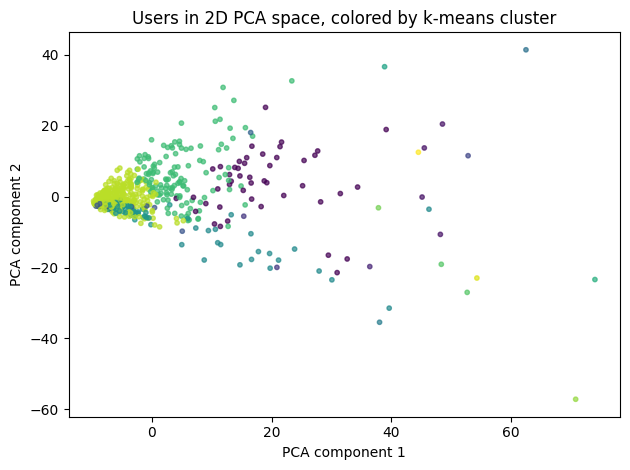

<Figure size 640x480 with 0 Axes>

In [330]:
# 2D PCA projection of users colored by cluster

# 1) Fit PCA on the user-item matrix (filled with 0.0 for missing ratings)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
user_coords_2d = pca.fit_transform(user_item_filled.values)

# user_coords_2d is an array of shape (n_users, 2)
x_coords = user_coords_2d[:, 0]
y_coords = user_coords_2d[:, 1]

plt.figure()
# Scatter plot of users, colored by cluster index.
plt.scatter(x_coords, y_coords, c=user_clusters, alpha=0.7, s=10)

plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.title("Users in 2D PCA space, colored by k-means cluster")
plt.tight_layout()
plt.show()


> The clusters appear highly overlapping, with one very large cluster and several smaller ones, which is consistent with the relatively high Davies–Bouldin index and the limited performance improvement of the cluster-based recommender over the popularity baseline.

---

## 4. Content-Based Module (TF-IDF on Genres)

So far, we used only rating information (collaborative signals).  
In this step, we introduce a simple **content-based** representation using movie genres.

This will be the content-based piece of our hybrid recommender.




### 4.0 Top genres by frequency

Using the `genres_str` field, we can count how often each genre appears across
all movies. This gives an overview of which genres are most common in the dataset.


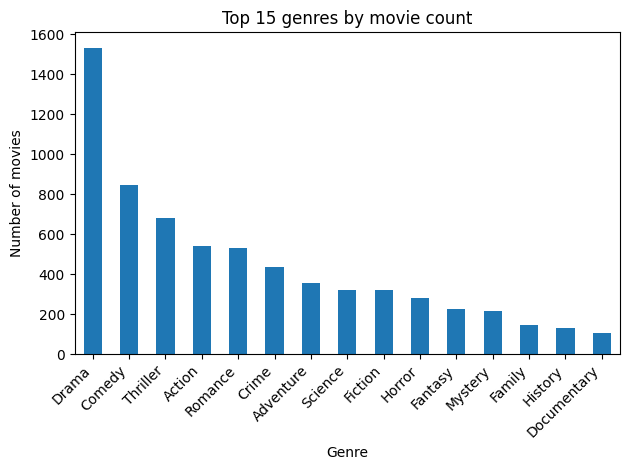

In [291]:
# Top genres by frequency

# Split the genres_str into individual genre tokens
genre_tokens = movies['genres_str'].str.split()

# Explode into long form: one row per (movie, genre)
genre_expanded = movies[['movieId']].copy()
genre_expanded = genre_expanded.join(
    movies['genres_str'].str.split().explode().rename('genre')
)

# Drop missing/empty genres
genre_expanded = genre_expanded.dropna(subset=['genre'])
genre_expanded = genre_expanded[genre_expanded['genre'] != ""]

# Count frequency of each genre
genre_counts = genre_expanded['genre'].value_counts()

# Take top 15 genres for plotting
top_genres = genre_counts.head(15)

plt.figure()
top_genres.plot(kind='bar')

plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.title("Top 15 genres by movie count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




> Drama and Comedy are by far the most common categories, followed by Thriller, Action, and Romance, while genres such as Family, History, and Documentary are relatively rare, indicating that the catalogue is dominated by mainstream narrative genres.


### 4.1 TF-IDF representation

We build TF-IDF content features from genres and define similar movies.

In [295]:
# Build the TF-IDF matrix

# Replace missing values with empty strings to avoid errors
genres_corpus = movies['genres_str'].fillna('')

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(genres_corpus)

print("✅ TF-IDF matrix built.")
print("TF-IDF shape (n_movies x n_features):", tfidf_matrix.shape)


✅ TF-IDF matrix built.
TF-IDF shape (n_movies x n_features): (2831, 22)


### 4.2 Cosine similarity matrix
Compute pairwise cosine similarities between movies. This gives us a matrix where entry (i, j) is the similarity between movie i and movie j
based purely on their genres.

In [298]:
content_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print("Cosine similarity matrix shape:", content_sim.shape)

Cosine similarity matrix shape: (2831, 2831)


### 4.3 check similar movies
    Return the top-N movies that are most similar to the given movie_id based on TF-IDF cosine similarity over genres.



In [301]:
# Create mappings between movieId and row indices in the movies DataFrame
# We assume that the index of 'movies' matches the row order in tfidf_matrix/content_sim.

movieid_to_idx = {mid: idx for idx, mid in enumerate(movies['movieId'])}
idx_to_movieid = {idx: mid for mid, idx in movieid_to_idx.items()}


def similar_movies(movie_id: int, top_n: int = 10) -> pd.DataFrame:
    """
    Return the top-N movies that are most similar to the given movie_id
    based on TF-IDF cosine similarity over genres.

    Parameters
    ----------
    movie_id : int
        ID of the query movie.
    top_n : int
        Number of similar movies to return.

    Returns
    -------
    pd.DataFrame
        A DataFrame with:
        - movieId
        - title
        - similarity (cosine similarity score)
    """
    if movie_id not in movieid_to_idx:
        raise ValueError(f"movie_id {movie_id} not found in movies table")

    # Index of the query movie in the similarity matrix
    idx = movieid_to_idx[movie_id]

    # Similarity scores to all other movies
    sims = content_sim[idx]

    # Sort indices by similarity (highest first)
    # We skip index 'idx' itself (the same movie)
    sorted_indices = np.argsort(sims)[::-1]  # descending order
    sorted_indices = [i for i in sorted_indices if i != idx]

    # Take the top_n most similar movies
    top_indices = sorted_indices[:top_n]

    # Map back to movieIds
    top_movie_ids = [idx_to_movieid[i] for i in top_indices]
    top_scores = [sims[i] for i in top_indices]

    # Build a result DataFrame
    result = pd.DataFrame({
        'movieId': top_movie_ids,
        'similarity': top_scores
    })

    # Attach titles
    result = result.merge(movies[['movieId', 'title']], on='movieId', how='left')

    # Reorder columns for readability
    result = result[['movieId', 'title', 'similarity']]

    return result

Example: list top-5 similar movies for *Heat* (or another title).

In [304]:
# Pick an example movie: the first one in the movies table
example_movie_id = int(movies['movieId'].iloc[0])
example_movie_title = movies.loc[movies['movieId'] == example_movie_id, 'title'].iloc[0]

print(f"\nExample movie: {example_movie_title} (movieId={example_movie_id})")
print("Top-5 most similar movies by genres:")

similar_example = similar_movies(example_movie_id, top_n=5)
display(similar_example)



Example movie: Heat (movieId=949)
Top-5 most similar movies by genres:


,movieId,title,similarity
0,3515,I'll Sleep When I'm Dead,1.0
1,247,The Killing,1.0
2,1619,The Way of the Gun,1.0
3,4639,Best Seller,1.0
4,111,Scarface,1.0




> To construct content-based features, we applied TF-IDF to the `genres_str` field, obtaining a 2831 × 22 matrix where each movie is represented by a 22-dimensional genre vector. The resulting cosine-similarity matrix (2831 × 2831) allows us to query movies with similar genre profiles. As a sanity check, using *Heat* as a query movie returns crime–action–drama titles such as *Scarface* and *The Way of the Gun* with cosine similarity 1.0, confirming that the TF-IDF representation correctly groups movies that share identical or very similar genre combinations. However, this also highlights a limitation: with only coarse genre labels, many movies end up with almost identical vectors, so the content signal is relatively weak and not very discriminative.


---

## 5. Hybrid Recommender

We now build the **hybrid recommender**, which combines:

- Collaborative information from **user clusters** (k-means on rating vectors).
- Content-based information from **TF-IDF genre similarity**.

This produces a personalised recommender that uses both “people like you” and “movies similar to what you like”.



### 5.1 Hybrid candidate generation
- Definition of “liked movies” (rating ≥ 4.0).
- Combine:
  - cluster-based candidates
  - content-based similar movies
- Remove already rated movies.

### 5.2 Hybrid scoring
- Compute `cluster_score` and `content_score` for each candidate.
- Final score: `0.7 * cluster_score + 0.3 * content_score`.

In [ ]:
# === Define the hybrid recommender that combines cluster + content ===

def hybrid_recommend(user_id: int,
                     top_n: int = 10,
                     rating_threshold: float = 4.0) -> pd.DataFrame:
    """
    Hybrid recommender that combines:
      - cluster-based collaborative signal (ratings from users in the same cluster)
      - content-based signal (TF-IDF genre similarity).

    Parameters
    ----------
    user_id : int
        Target user for whom we want recommendations.
    top_n : int
        Number of movies to recommend.
    rating_threshold : float
        Minimum rating to consider a movie as "liked" by the user.

    Returns
    -------
    pd.DataFrame
        Table of recommended movies with:
        - movieId
        - title
        - final_score
        - cluster_score
        - content_score
    """
    # Ensure the user exists in the training data / clustering
    if user_id not in user_to_cluster:
        raise ValueError(f"user_id {user_id} not found in training set")

    # --- 1) Movies that the user liked in the TRAIN set ---
    user_hist = train_ratings[
        (train_ratings["userId"] == user_id) &
        (train_ratings["rating"] >= rating_threshold)
    ]["movieId"].unique()

    # If the user has no "liked" movies, fall back to pure cluster-based
    if len(user_hist) == 0:
        print("Hybrid: user has no liked movies in train; falling back to cluster-only.")
        cluster_only = recommend_from_cluster(user_id, top_n=top_n, min_ratings=3)
        return cluster_only

    # --- 2) Cluster-based candidates ---
    # We request more than top_n here, because we will merge with content-based candidates.
    cluster_recs = recommend_from_cluster(user_id, top_n=top_n * 5, min_ratings=3)
    cluster_candidate_ids = set(cluster_recs["movieId"].values)

    # --- 3) Content-based candidates using TF-IDF similarity ---
    content_candidate_ids = set()
    for mid in user_hist:
        try:
            # Get movies similar to each liked movie
            sims_df = similar_movies(mid, top_n=20)
            content_candidate_ids.update(sims_df["movieId"].values)
        except ValueError:
            # If a movieId is missing from TF-IDF mappings, just skip it
            continue

    # --- 4) Merge candidates and remove movies already seen by the user ---
    all_candidates = cluster_candidate_ids.union(content_candidate_ids)

    # Movies already rated by the user in the training data
    seen_movies = set(
        train_ratings[train_ratings["userId"] == user_id]["movieId"].values
    )

    # Remove seen movies
    candidate_ids = [mid for mid in all_candidates if mid not in seen_movies]

    # If we end up with no candidates, again fall back to cluster-only
    if len(candidate_ids) == 0:
        print("Hybrid: no unseen candidates; falling back to cluster-only.")
        cluster_only = recommend_from_cluster(user_id, top_n=top_n, min_ratings=3)
        return cluster_only

    # --- 5) Compute cluster_score and content_score for each candidate ---

    # Identify the cluster of this user and gather cluster ratings
    cluster_id = user_to_cluster[user_id]
    cluster_users = user_cluster_df[user_cluster_df["cluster"] == cluster_id]["userId"]
    cluster_ratings = train_ratings[train_ratings["userId"].isin(cluster_users)]

    # Mean rating per movie in this cluster
    cluster_movie_mean = cluster_ratings.groupby("movieId")["rating"].mean()
    global_cluster_mean = cluster_movie_mean.mean()  # fallback if movie not seen in cluster

    scores = []

    for mid in candidate_ids:
        # --- cluster_score ---
        cluster_score = cluster_movie_mean.get(mid, global_cluster_mean)

        # --- content_score ---
        # We measure how similar this candidate movie is to any of the movies
        # the user liked, and take the maximum similarity as the content_score.
        content_score = 0.0
        if mid in movieid_to_idx:
            cand_idx = movieid_to_idx[mid]
            sims_to_liked = []

            for liked_mid in user_hist:
                if liked_mid in movieid_to_idx:
                    liked_idx = movieid_to_idx[liked_mid]
                    sims_to_liked.append(content_sim[cand_idx, liked_idx])

            if sims_to_liked:
                content_score = max(sims_to_liked)

        # Combine the two scores into a final score
        final_score = 0.7 * cluster_score + 0.3 * content_score

        scores.append({
            "movieId": mid,
            "cluster_score": cluster_score,
            "content_score": content_score,
            "final_score": final_score
        })

    # Put everything into a DataFrame
    scores_df = pd.DataFrame(scores)

    # Sort by final_score and take the top_n movies
    scores_df = scores_df.sort_values(by="final_score", ascending=False).head(top_n)

    # Attach movie titles
    scores_df = scores_df.merge(movies[["movieId", "title"]], on="movieId", how="left")

    # Reorder columns for readability
    scores_df = scores_df[["movieId", "title", "final_score", "cluster_score", "content_score"]]

    return scores_df

Now we show example table for one user with:
  - `title`, `final_score`, `cluster_score`, `content_score`.

In [45]:
example_user_id = int(user_item.index[0])
print(f"Hybrid recommendations for example user: {example_user_id}")

hybrid_example = hybrid_recommend(example_user_id, top_n=10, rating_threshold=4.0)
display(hybrid_example)


Hybrid recommendations for example user: 1


,movieId,title,final_score,cluster_score,content_score
0,1819,"You, Me and Dupree",3.800000,5.000000,1.000000
1,2132,Totally Blonde,3.691248,5.000000,0.637494
2,2064,While You Were Sleeping,3.655296,4.833333,0.906544
3,3083,Mr. Smith Goes to Washington,3.654439,5.000000,0.514796
4,2202,Lassie Come Home,3.500000,5.000000,0.000000
5,5902,A Bridge Too Far,3.500000,5.000000,0.000000
6,3089,Red River,3.500000,5.000000,0.000000
7,1939,Laura,3.500000,5.000000,0.000000
8,162,Edward Scissorhands,3.490950,4.800000,0.436499
9,5064,Carry On Doctor,3.457915,4.666667,0.637494





The table illustrates the behaviour of the hybrid recommender for an example user. For each candidate movie $(m)$, we compute a $\text{cluster\_score}$ as the mean rating of $(m)$ among users in the same k-means cluster, and a $\text{content\_score}$ as the maximum $\text{TF-IDF}$ cosine similarity between $(m)$ and any movie that the user liked in the training set. The final ranking score is defined as

$$\text{final\_score}(m) = 0.7 \cdot \text{cluster\_score}(m) + 0.3 \cdot \text{content\_score}(m),$$

which explains why movies with both high cluster scores and non-zero content scores are ranked above items that rely purely on the cluster signal (where $\text{content\_score} = 0$). Qualitatively, the top recommendations look reasonable for the user’s profile, indicating that the hybrid mechanism behaves as intended on individual cases.




---

## 6 Evaluation

To compare the three recommenders, we use a simple metric called **hit-rate@10**.

We will compute hit-rate@10 for:
- the **popularity** baseline,
- the **cluster-only** recommender,
- and the **hybrid** recommender.

This allows us to see whether clustering and the hybrid actually improve over the simple popularity model.


In [ ]:
# === Evaluation using hit-rate@10 ===

def hit_rate_at_k(model_func,
                  k: int = 10,
                  n_users_eval: int = 200,
                  name: str = "model") -> float:
    """
    Compute hit-rate@k for a given recommendation function.

    Parameters
    ----------
    model_func : callable
        A function of the form model_func(user_id, top_n) -> DataFrame
        returning a column 'movieId' with the recommended movies.
    k : int
        The length of the recommendation list (top-k).
    n_users_eval : int
        Number of users from the test set to sample for evaluation.
    name : str
        Name of the model (used only for printing).

    Returns
    -------
    float
        The hit-rate@k value.
    """
    # All users that appear in the test ratings
    users_in_test = test_ratings["userId"].unique()

    # Sample a subset of users to speed up evaluation (if many users)
    n_sample = min(n_users_eval, len(users_in_test))
    users_sample = np.random.choice(users_in_test, size=n_sample, replace=False)

    hits = 0
    total = 0

    for uid in users_sample:
        # Movies this user rated in the test set (ground truth)
        test_movies_uid = test_ratings[test_ratings["userId"] == uid]["movieId"].unique()
        if len(test_movies_uid) == 0:
            continue

        try:
            recs = model_func(int(uid), top_n=k)
        except Exception:
            # If the model fails for some user, just skip that user
            continue

        # Recommended movieIds
        rec_ids = set(recs["movieId"].values)

        # Check if there is at least one overlap with the test movies
        if len(rec_ids.intersection(test_movies_uid)) > 0:
            hits += 1
        total += 1

    hit_rate = hits / total if total > 0 else 0.0
    print(f"{name} Hit-rate@{k}: {hit_rate:.3f}  (over {total} users)")
    return hit_rate


# --- Small wrapper so the popularity model matches the expected signature (user_id, top_n) ---

def recommend_popular_for_user(user_id: int, top_n: int = 10):
    """
    Wrapper around recommend_popular so that it accepts a user_id
    (even though it ignores it) and returns a DataFrame of recommendations.
    """
    return recommend_popular(top_n=top_n, min_ratings=20)

In [48]:
# --- Run evaluation for the three models ---

hr_pop = hit_rate_at_k(
    recommend_popular_for_user,
    k=10,
    n_users_eval=200,
    name="Popularity"
)

hr_cluster = hit_rate_at_k(
    recommend_from_cluster,
    k=10,
    n_users_eval=200,
    name="Cluster-only"
)

hr_hybrid = hit_rate_at_k(
    hybrid_recommend,
    k=10,
    n_users_eval=200,
    name="Hybrid"
)

print("\nSummary of Hit-rate@10:")
print(f"  Popularity : {hr_pop:.3f}")
print(f"  Cluster-only: {hr_cluster:.3f}")
print(f"  Hybrid     : {hr_hybrid:.3f}")


Popularity Hit-rate@10: 0.210  (over 200 users)
Cluster-based recommender: no candidates found, falling back to popularity.
Cluster-based recommender: no candidates found, falling back to popularity.
Cluster-based recommender: no candidates found, falling back to popularity.
Cluster-only Hit-rate@10: 0.210  (over 200 users)
Hybrid: user has no liked movies in train; falling back to cluster-only.
Cluster-based recommender: no candidates found, falling back to popularity.
Cluster-based recommender: no candidates found, falling back to popularity.
Cluster-based recommender: no candidates found, falling back to popularity.
Cluster-based recommender: no candidates found, falling back to popularity.
Hybrid Hit-rate@10: 0.037  (over 160 users)

Summary of Hit-rate@10:
  Popularity : 0.210
  Cluster-only: 0.210
  Hybrid     : 0.037


Finally, we visualise the hit-rate@10 for the three models (popularity, 
cluster-only, and hybrid) in a simple bar chart. This makes the performance
differences easier to see at a glance.


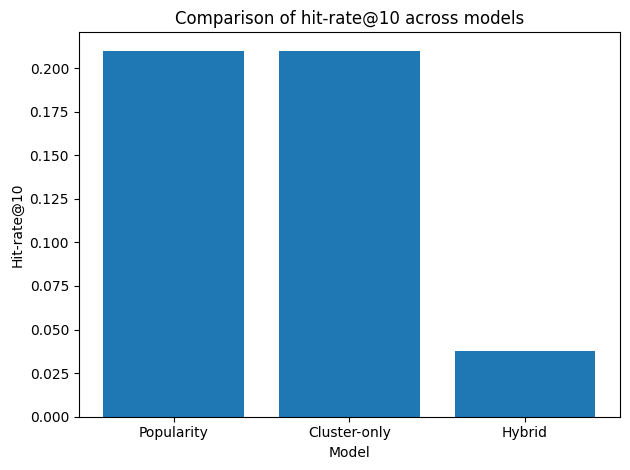

In [51]:
# Bar chart of hit-rate@10 for each model

model_names = ["Popularity", "Cluster-only", "Hybrid"]
hit_rates = [hr_pop, hr_cluster, hr_hybrid]

plt.figure()
plt.bar(model_names, hit_rates)

plt.xlabel("Model")
plt.ylabel("Hit-rate@10")
plt.title("Comparison of hit-rate@10 across models")
plt.tight_layout()
plt.show()




> “We evaluated the three recommendation strategies using hit-rate@10 on a sample of test users. The simple popularity baseline achieved a hit-rate@10 of 0.210, meaning that in about 21% of the users at least one of their held-out movies appeared in the top-10 list.
>
> The cluster-only recommender obtained exactly the same hit-rate (0.210). This is partly explained by the fact that, for a non-trivial fraction of users, the cluster-based method could not find enough unseen movies satisfying the minimum rating threshold and therefore fell back to the global popularity list, effectively behaving like the baseline.
>
> 
> The hybrid recommender performed substantially worse, with a hit-rate@10 of only 0.037 . In many cases the hybrid model also had to fall back to the cluster-only or popularity recommendations, and when the content signal was used, the combination of sparse ratings, coarse genre-based features, and strict candidate filtering often failed to retrieve the test items.
>
> These results confirm that, in its current form, the proposed hybrid design does not improve over the simpler baselines and even degrades performance.


---

## 7 Results and Discussion



We evaluated the three recommender variants using hit-rate@10 on a held-out test set. 
For each user in a random sample of the test users, we checked whether at least one of 
their test-set movies appeared in the top-10 recommendations produced by a given model.


Overall, the experiment shows that while the tools from the course (k-means 
clustering) and an external method (TF-IDF on genres) can be combined into a 
hybrid system, the specific implementation here is not yet effective under the 
chosen evaluation metric. A more careful design and tuning of the hybrid strategy, 
or the use of richer content features and more suitable collaborative models 
(e.g., matrix factorisation), would likely be necessary to realise the potential 
benefits of hybrid recommendation in this setting.

